In [1]:
# 加载必要的库
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
# gensim用来加载word vector
from gensim.models import KeyedVectors
import warnings
warnings.filterwarnings
# bz2用来解压
import bz2

In [3]:
# 解压词向量
with open('embeddings/sngs.zhihu.bigram', 'wb') as new_file, open('embeddings/sgns.zhihu.bigram.bz2','rb') as file:
    decompressor = bz2.BZ2Decompressor()
    for data in iter(lambda : file.read(100 * 1024), b''):
        new_file.write(decompressor.decompress(data))

In [4]:
# 使用gensim加载预训练中文分词embedding
cn_model = KeyedVectors.load_word2vec_format('embeddings/sgns.zhihu.bigram', binary=False, unicode_errors='ignore')

In [5]:
# 每个词的维度均为300维
embedding_dim = cn_model['山东大学'].shape[0]
print('词向量的长度为:{}'.format(embedding_dim))

词向量的长度为:300


In [6]:
# 300维的向量
cn_model['山东大学']

array([-2.603470e-01,  3.677500e-01, -2.379650e-01,  5.301700e-02,
       -3.628220e-01, -3.212010e-01, -1.903330e-01,  1.587220e-01,
       -7.156200e-02, -4.625400e-02, -1.137860e-01,  3.515600e-01,
       -6.408200e-02, -2.184840e-01,  3.286950e-01, -7.110330e-01,
        1.620320e-01,  1.627490e-01,  5.528180e-01,  1.016860e-01,
        1.060080e-01,  7.820700e-01, -7.537310e-01, -2.108400e-02,
       -4.758250e-01, -1.130420e-01, -2.053000e-01,  6.624390e-01,
        2.435850e-01,  9.171890e-01, -2.090610e-01, -5.290000e-02,
       -7.969340e-01,  2.394940e-01, -9.028100e-02,  1.537360e-01,
       -4.003980e-01, -2.456100e-02, -1.717860e-01,  2.037790e-01,
       -4.344710e-01, -3.850430e-01, -9.366000e-02,  3.775310e-01,
        2.659690e-01,  8.879800e-02,  2.493440e-01,  4.914900e-02,
        5.996000e-03,  3.586430e-01, -1.044960e-01, -5.838460e-01,
        3.093280e-01, -2.828090e-01, -8.563400e-02, -5.745400e-02,
       -2.075230e-01,  2.845980e-01,  1.414760e-01,  1.678570e

In [7]:
# 计算相似度
cn_model.similarity('橘子', '橙子')

0.66128117

In [8]:
# 上述的相似度为余弦相似度，实质上dot（'橘子'/|'橘子'|， '橙子'/|'橙子'| ）
np.dot(cn_model['橘子']/np.linalg.norm(cn_model['橘子']),
       cn_model['橙子']/np.linalg.norm(cn_model['橙子']))

0.6612812

In [9]:
# 找出最相近的词
cn_model.most_similar(positive=['大学'], topn=10)

[('高中', 0.7247823476791382),
 ('本科', 0.676853597164154),
 ('研究生', 0.6244412660598755),
 ('中学', 0.6088205575942993),
 ('大学本科', 0.5959085822105408),
 ('初中', 0.5883588790893555),
 ('读研', 0.5778335332870483),
 ('职高', 0.5767995715141296),
 ('大学毕业', 0.5767451524734497),
 ('师范大学', 0.5708829164505005)]

In [11]:
# 找出不同的词
test_words = '老师 会计师 程序员 律师 医生 老人'
test_words_result = cn_model.doesnt_match(test_words.split())
print('在{}中:\n不是一类的词是:{}'.format(test_words, test_words_result))

在老师 会计师 程序员 律师 医生 老人中:
不是一类的词是:老人


/Users/lidianxiang/anaconda3/envs/tensorflow/lib/python3.6/site-packages/gensim/models/keyedvectors.py:877: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


In [13]:
cn_model.most_similar(positive=['女人','劈腿'],negative=['男人'],topn=5)

[('出轨', 0.6100173592567444),
 ('脚踏两只船', 0.5825897455215454),
 ('打胎', 0.5778396129608154),
 ('移情别恋', 0.5618439316749573),
 ('未婚先孕', 0.5577656626701355)]

In [14]:
# 加载训练语料
# 将语料.zip解压后得到两个文件夹：pos,neg
import os
pos_txts = os.listdir('./语料/pos/')
neg_txts = os.listdir('./语料/neg/')
print('样本总数为：{}'.format(len(pos_txts) + len(neg_txts)))

样本总数为：4000


In [15]:
train_texts_orig = []
train_target = []
with open('positive_samples.txt', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic['text'])
        train_target.append(dic['label'])
        
with open('negative_samples.txt', encoding='utf-8') as f:
    lines = f.readlines()
    for line in lines:
        dic = eval(line)
        train_texts_orig.append(dic['text'])
        train_target.append(dic['label'])

In [16]:
len(train_texts_orig)

4000

In [17]:
# 使用tensorflow的keras接口来建模
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, LSTM, Bidirectional
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from tensorflow.python.keras.optimizers import RMSprop, Adam
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

In [18]:
# 分词和tokenize
train_tokens = []
for text in train_texts_orig:
    #text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、～@#])]")
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # jieba 分词
    cut = jieba.cut(text)
    # 将生成器转为list列表
    cut_list = [i for i in cut]
    for i, word in enumerate(cut_list):
        try:
            # 将词转换为suoyin
            cut_list[i] = cn_model.vocab[word].index
        except KeyError:
            # 若词不在字典中，则输出零
            cut_list[i] = 0
    train_tokens.append(cut_list)


Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/pw/f22wybpj5zd97xm6dpkl7_fh0000gn/T/jieba.cache
Loading model cost 0.689 seconds.
Prefix dict has been built succesfully.


In [19]:
# 获得所有tokens的长度
num_tokens = [len(token) for token in train_tokens]
num_tokens = np.array(num_tokens)
# 平均token的长度
np.mean(num_tokens)

71.4495

In [20]:
# 最长的tokens的长度
np.max(num_tokens)

1540

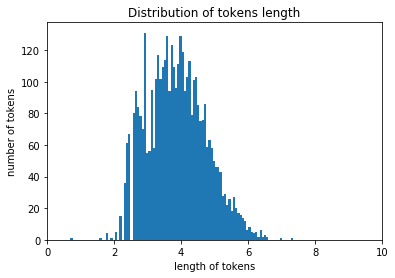

In [21]:
plt.hist(np.log(num_tokens), bins=100)
plt.xlim((0, 10))
plt.xlabel('length of tokens')
plt.ylabel('number of tokens')
plt.title('Distribution of tokens length')
plt.show()

In [22]:
# 取tokens平均值加上两个tokens的标准差
# 假设tokens的长度的分布为正态分布，则max_tokens这个值可以覆盖到95%左右的样本
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

236

In [23]:
# 取tokens的长度为236时，大约可以覆盖到95%
# 对于长度不足的样本进行padding，超长的进行修剪
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.9565

In [24]:
# 反向tokenize
# 定义一个函数，用来将索引转换成可阅读的文本，这个对debug很重要
def reverse_tokens(tokens):
    text = ''
    for i in tokens:
        if i != 0:
            text = text + cn_model.index2word[i]
        else:
            text = text + ' '
    return text



In [25]:
reverse = reverse_tokens(train_tokens[0])
reverse

'早餐太差无论去多少人那边也不加食品的酒店应该重视一下这个问题了房间本身很好'

In [27]:
# 原始文本
train_texts_orig[0]

'早餐太差，无论去多少人，那边也不加食品的。酒店应该重视一下这个问题了。\n\n房间本身很好。'

In [28]:
# 准备embedding_matrix
# 这里因为样本只有4000，所以值考虑300维
embedding_dim

300

In [29]:
# 只使用前50000个词
num_words = 50000
embedding_matrix = np.zeros((num_words, embedding_dim))
# embedding_matrix为一个[num_words, embedding_dim]的矩阵
# 维度为50000 * 300
for i in range(num_words):
    embedding_matrix[i,:] = cn_model[cn_model.index2word[i]]
embedding_matrix = embedding_matrix.astype('float32')

In [30]:
# 检查index是否对应
# 输出300的意义为长度为300的embedding向量一一对应
np.sum(cn_model[cn_model.index2word[333]] == embedding_matrix[333])

300

In [31]:
# embedding_matrix的维度
# 这个维度为keras的要求，后续会在模型中用到
embedding_matrix.shape

(50000, 300)

In [32]:
# 进行padding和truncating
# 输入的train_tokens是一个list
# 返回的train_pad是一个numpy_array
train_pad = pad_sequences(train_tokens, maxlen=max_tokens,
                         padding='pre', truncating='pre')

In [33]:
# 超过50000词向量的词用0代替
train_pad[train_pad >= num_words] = 0

In [34]:
# 可见padding之后前面的tokens全变成0，文本在最后面
train_pad[33]

array([    0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,

In [35]:
# 准备target向量，前2000样本为1，后2000样本为0
train_target = np.array(train_target)

In [36]:
# 进行训练和测试的样本的分割
from sklearn.model_selection import train_test_split

In [37]:
# 90%的样本用来进行训练，剩余10%用来进行测试
X_train, X_test, y_train, y_test = train_test_split(train_pad,
                                                   train_target,
                                                   test_size=0.1,
                                                   random_state=12)

In [38]:
# 查看训练样本
print(reverse_tokens(X_train[35]))
print('class:', y_train[35])

                                                                                                                                                                                                                        房间很大还有海景阳台走出酒店就是沙滩非常不错唯一遗憾的就是不能刷 不方便
class: 1


In [39]:
# 使用keras搭建LSTM模型
model = Sequential()
model.add(Embedding(num_words,
                   embedding_dim,
                   weights=[embedding_matrix],
                   input_length=max_tokens,
                   trainable=False))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(LSTM(units=16, return_sequences=False))

In [40]:
model.add(Dense(1, activation='sigmoid'))
optimizer = Adam(lr=1e-3)

In [41]:
model.compile(loss='binary_crossentropy',
             optimizer=optimizer,
             metrics=['accuracy'])

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 236, 300)          15000000  
_________________________________________________________________
bidirectional (Bidirectional (None, 236, 128)          186880    
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                9280      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 15,196,177
Trainable params: 196,177
Non-trainable params: 15,000,000
_________________________________________________________________


In [43]:
# 建立一个权重的存储点
path_checkpoint = 'sentiment_checkpoint.keras'
checkpoint = ModelCheckpoint(filepath=path_checkpoint, monitor='val_loss',
                            verbose=1, save_weights_only=True,
                            save_best_only=True)

In [44]:
# 尝试加载已训练的模型
try:
    model.load_weights(path_checkpoint)
except Exception as e:
    print(e)

In [45]:
# 定义early_stopping
# 如果3个epoch内validation_loss没有改善则停止训练
earlystopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

In [46]:
# 自动降低learing_rate
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.1, min_lr=1e-8, patience=0,
                                verbose=1)

In [47]:
# 定义callback函数
callbacks = [
    earlystopping,
    checkpoint,
    lr_reduction
]

In [48]:
# 开始训练
model.fit(X_train, y_train,
         validation_split=0.1,
         epochs=20,
         batch_size=128,
         callbacks=callbacks)

Train on 3240 samples, validate on 360 samples
Epoch 1/20
3200/3240 [============================>.] - ETA: 0s - loss: 0.2988 - acc: 0.8750
Epoch 00001: val_loss improved from inf to 0.30273, saving model to sentiment_checkpoint.keras
3240/3240 [==============================] - 19s 6ms/step - loss: 0.2992 - acc: 0.8744 - val_loss: 0.3027 - val_acc: 0.8861
Epoch 2/20
3200/3240 [============================>.] - ETA: 0s - loss: 0.2538 - acc: 0.9016
Epoch 00002: val_loss did not improve from 0.30273

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
3240/3240 [==============================] - 17s 5ms/step - loss: 0.2545 - acc: 0.9012 - val_loss: 0.3451 - val_acc: 0.8667
Epoch 3/20
3200/3240 [============================>.] - ETA: 0s - loss: 0.2269 - acc: 0.9169
Epoch 00003: val_loss did not improve from 0.30273

Epoch 00003: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
3240/3240 [==============================] - 18s 5ms/step - loss:

In [49]:
result = model.evaluate(X_test, y_test)
print('Accuracy:{0:.2%}'.format(result[-1]))

400/400 [==============================] - 1s 4ms/step
Accuracy:87.00%


In [54]:
def predict_sentiment(text):
    print(text)
    # 去标点
    text = re.sub("[\s+\.\!\/_,$%^*(+\"\']+|[+——！，。？、~@#￥%……&*（）]+", "",text)
    # 分词
    cut = jieba.cut(text)
    cut_list = [ i for i in cut ]
    # tokenize
    for i, word in enumerate(cut_list):
        try:
            cut_list[i] = cn_model.vocab[word].index
            if cut_list[i] >= 50000:
                cut_list[i] = 0
        except KeyError:
            cut_list[i] = 0
    # padding
    tokens_pad = pad_sequences([cut_list], maxlen=max_tokens,
                              padding='pre', truncating='pre')
    # 预测
    result = model.predict(x=tokens_pad)
    coef = result[0][0]
    if coef >= 0.5:
        print('是一例正面评价', 'output=%.2f' % coef)
    else:
        print('是一例负面评价', 'output=%.2f' % coef)

In [55]:
test_list = [
    '酒店设施不是新的，服务态度很不好',
    '酒店卫生条件非常不好',
    '床铺非常舒适',
    '房间很凉，不给开暖气',
    '房间很凉爽，空调冷气很足',
    '酒店环境不好，住宿体验很不好',
    '房间隔音不到位' ,
    '晚上回来发现没有打扫卫生',
    '因为过节所以要我临时加钱，比团购的价格贵'
]
for text in test_list:
    predict_sentiment(text)

酒店设施不是新的，服务态度很不好
是一例负面评价 output=0.08
酒店卫生条件非常不好
是一例负面评价 output=0.07
床铺非常舒适
是一例正面评价 output=0.87
房间很凉，不给开暖气
是一例负面评价 output=0.13
房间很凉爽，空调冷气很足
是一例正面评价 output=0.76
酒店环境不好，住宿体验很不好
是一例负面评价 output=0.05
房间隔音不到位
是一例负面评价 output=0.13
晚上回来发现没有打扫卫生
是一例负面评价 output=0.26
因为过节所以要我临时加钱，比团购的价格贵
是一例负面评价 output=0.04


In [56]:
y_pred = model.predict(X_test)
y_pred = y_pred.T[0]
y_pred = [1 if p >=0.5 else 0 for p in y_pred]
y_pred = np.array(y_pred)

In [57]:
y_actual = np.array(y_test)

In [58]:
# 找出错误分类的索引
misclassified = np.where(y_pred != y_actual)[0]

In [59]:
# 输出所有错误分类的索引
len(misclassified)
print(len(X_test))

400


In [60]:
# 找出错误分类的样本
idx = 101
print(reverse_tokens(X_test[idx]))
print('预测的分类', y_pred[idx])
print('实际的分类', y_actual[idx])

                                                                                                                                                        由于2007年 有一些新问题可能还没来得及解决我因为工作需要经常要住那里所以慎重的提出以下 ：1 后 的 淋浴喷头的位置都太高我换了房间还是一样很不好用2 后的一些管理和服务还很不到位尤其是前台入住和 时代效率太低每次 都超过10分钟好像不符合 宾馆的要求
预测的分类 0
实际的分类 1
